In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

class NormalNAMLSS(nn.Module):
    def __init__(self, n_covariates, hidden_size=8, intercept=False):
        super(NormalNAMLSS, self).__init__()

        self.submodules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 2)
            ) for _ in range(n_covariates)
        ])

        self.use_intercept = intercept
        if self.use_intercept:
            self.intercept = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
        x = torch.stack(param_mat_list, dim=1)
        mu_components = x[:, :, 0]
        sigma_components = F.softplus(x[:, :, 1])

        mu = torch.sum(mu_components, dim=1).unsqueeze(dim=1)
        sigma = torch.sum(sigma_components, dim=1).unsqueeze(dim=1)

        if self.use_intercept:
            mu = mu + self.intercept[0]
            sigma = sigma + F.softplus(self.intercept[1])

        return mu, sigma

    def nll_loss(self, mu, sigma, y_true, robustness_factor=None):
        normal_dist = dist.Normal(mu, sigma)
        # log_likelihood = normal_dist.log_prob(y_true).sum()
        log_likelihood = normal_dist.log_prob(y_true).mean()

        if robustness_factor is not None:
            # log_likelihood = torch.log((1 + torch.exp(normal_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).sum()
            log_likelihood = torch.log((1 + torch.exp(normal_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).mean()

        nll = -log_likelihood
        return nll


    def fit(self, X_train, y_train, X_val=None, y_val=None, n_epochs=10000, lr=1e-3, weight_decay=0.0, 
            early_stopping_patience=10, robustness_factor=None):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(n_epochs):
            self.train()

            # Forward pass and loss computation
            mu, sigma = self.forward(X_train)
            train_loss = self.nll_loss(mu, sigma, y_train, robustness_factor)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            val_loss = None
            if X_val is not None and y_val is not None:
                self.eval()
                with torch.no_grad():
                    mu_val, sigma_val = self.forward(X_val)
                    val_loss = self.nll_loss(mu_val, sigma_val, y_val, robustness_factor).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = self.state_dict()
                else:
                    patience_counter += 1

                if (patience_counter >= early_stopping_patience) and (epoch >= 1000):
                    print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                    self.load_state_dict(best_model_state)
                    break

            if epoch % 100 == 0 or val_loss is not None:
                # print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}" if val_loss else f"Epoch {epoch} - Train Loss: {train_loss.item():.4f}")
                pass

        return self
    
    def predict(self, x):
        mu, sigma = self.forward(x)

        mu = mu.detach()
        sigma = sigma.detach()

        return mu, sigma
        

    def marginal_effects(self, x):
        with torch.no_grad():
            param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
            x = torch.stack(param_mat_list, dim=1)
            mu_components = x[:, :, 0].detach().cpu().numpy()
            sigma_components = F.softplus(x[:, :, 1]).detach().cpu().numpy()
        return mu_components, sigma_components

In [66]:
def rho_gradient(z, c):
    return np.exp(z + c)/(1 + np.exp(z + c))

In [65]:
import numpy as np

def get_aeberhard_penalty(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, target_mdp):

    rob_vec = torch.tensor(list(np.arange(5, 0, -0.1)), dtype = torch.float32)
    n_var = X_train_scaled.shape[1]
    
    prev_mdp = 0
    best_rob = None

    for rob in rob_vec:
        prev_distance = abs(prev_mdp - target_mdp)
        w_b_vector = []

        candidate_model = NormalNAMLSS(n_var)
        candidate_model.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor = rob)
        mu, sigma = candidate_model.predict(X_train_scaled)

        normal_dist = dist.Normal(mu, sigma)

        for _ in range(10):
            y_b = torch.normal(mu, sigma)
            ll = normal_dist.log_prob(y_b)
            w_1b = rho_gradient(ll, rob)
            w_b = torch.sum(w_1b) / len(y_b)
            w_b_vector.append(w_b)

        current_mdp = 1 - torch.median(torch.tensor(w_b_vector, dtype = torch.float32))
        current_distance = abs(current_mdp - target_mdp)

        if current_distance > prev_distance:
            print(f"stopping at {best_rob} --> mdp: {prev_mdp * 100}%")
            break

        best_rob = rob
        prev_mdp = current_mdp

    return best_rob

In [20]:
import pandas as pd

hemoglobin = pd.read_csv("Hb-Anon.txt", delimiter="\t")
hemoglobin.head()

,VAL,PID,SEX,AGE
0,9.9,16454397634,M,698
1,13.6,94527474619,M,4538
2,14.4,84895945689,W,5830
3,11.3,99523414726,W,35
4,7.7,56793098059,W,612


In [57]:
import random

female_df = hemoglobin[hemoglobin["SEX"]=="W"][["AGE", "VAL"]]
female_df = female_df.to_numpy()

training_sample_indices = random.sample(range(1, len(female_df)), int(10000))
x_train = female_df[training_sample_indices, 0]
y_train = female_df[training_sample_indices, 1]

validation_sample_indices = random.sample(range(1, len(female_df)), int(10000))
x_val = female_df[validation_sample_indices, 0]
y_val = female_df[validation_sample_indices, 1]

testing_sample_indices = random.sample(range(1, len(female_df)), int(10000))
x_test = female_df[testing_sample_indices, 0]
y_test = female_df[testing_sample_indices, 1]

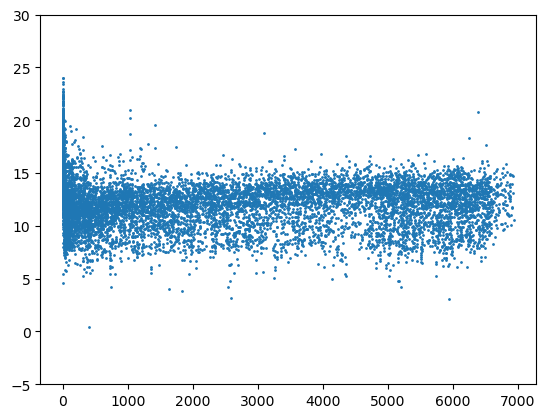

In [46]:
import matplotlib.pyplot as plt

plt.plot(x_test, y_test, "o", markersize = 1)
plt.ylim(-5, 30)

plt.show()

In [ ]:
# x_train = x_train.reshape(-1, 1)
# x_val = x_val.reshape(-1, 1)
# x_test = x_test.reshape(-1, 1)

# y_train = y_train.reshape(-1, 1)
# y_val = y_val.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

x_train = torch.tensor(x_train)
x_val = torch.tensor(x_val)
x_test = torch.tensor(x_test)

y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

In [64]:
from sklearn.preprocessing import StandardScaler

x_scaler, y_scaler = StandardScaler(), StandardScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)


In [67]:
robust_c = get_aeberhard_penalty(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled, 0.05)
strict_c = get_aeberhard_penalty(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled, 0.1)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
nam = NormalNAMLSS(1)

nam.fit(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled)



robust_nam = NormalNAMLSS(1)
strict_nam = NormalNAMLSS(1)